## 1. Loading Data:

In [1]:
%matplotlib inline
from __future__ import print_function

import pandas as pd
import numpy as np
from sklearn import cross_validation
import xgboost as xgb
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from matplotlib import rcParams

In [2]:
train_file = '../input/train.csv'
test_file = '../input/test.csv'
output_file = '../submissions/benchmark_predictions.csv'

print("Load the training, test and store data using pandas")
train = pd.read_csv(train_file, low_memory=False)
test = pd.read_csv(test_file, low_memory=False)
store = pd.read_csv("../input/store.csv", low_memory=False)

Load the training, test and store data using pandas


## 2. Exploratory Data Analysis

### 2.1. Look at the columns of train/test dataset.

In [3]:
print(train.info())
print('-'*40)
print(test.info())
print('-'*40)
print(store.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 77.6+ MB
None
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float

In [4]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1,1,0,0
1,2,3,4,2015-09-17,1,1,0,0
2,3,7,4,2015-09-17,1,1,0,0
3,4,8,4,2015-09-17,1,1,0,0
4,5,9,4,2015-09-17,1,1,0,0


### 2.2. Number of unique stores in training set.

In [6]:
print('Number of unique stores in train data: %d' %(len(train.Store.unique())))
print('Number of unique stores in train data: %d' %(len(test.Store.unique())))

Number of unique stores in train data: 1115
Number of unique stores in train data: 856


### 2.3. Look into correlations

In [7]:
train.corr()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
Store,1.000000,-0.000008,0.005126,0.024325,-0.000047,0.000058,0.000641
DayOfWeek,-0.000008,1.000000,-0.462125,-0.386445,-0.528963,-0.392925,-0.205388
Sales,0.005126,-0.462125,1.000000,0.894711,0.678472,0.452345,0.085124
Customers,0.024325,-0.386445,0.894711,1.000000,0.616768,0.316169,0.071568
Open,-0.000047,-0.528963,0.678472,0.616768,1.000000,0.295042,0.086171
Promo,0.000058,-0.392925,0.452345,0.316169,0.295042,1.000000,0.067483
SchoolHoliday,0.000641,-0.205388,0.085124,0.071568,0.086171,0.067483,1.000000


### 2.4. The influence of Open Feature on the sales:

In [8]:
print("The number of closed stores that zero sales: %d."%(train.loc[train.Open==0].Sales==0).sum())
print("The number of closed stores: %d."%len(train.loc[train.Open==0]))
print("Stores which where closed will definately have no sales!")

The number of closed stores that zero sales: 172817.
The number of closed stores: 172817.
Stores which where closed will definately have no sales!


In [9]:
print("Assume store open, if not provided")
test.fillna(1, inplace=True)

print("Consider only open stores for training. Closed stores wont count into the score.")
train = train.loc[train.Sales > 0]

Assume store open, if not provided
Consider only open stores for training. Closed stores wont count into the score.


In [10]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,844338.000000,844338.000000,844338.000000,844338.000000,844338,844338.000000,844338.000000
mean,558.421374,3.520350,6955.959134,762.777166,1,0.446356,0.193578
std,321.730861,1.723712,3103.815515,401.194153,0,0.497114,0.395102
min,1.000000,1.000000,46.000000,8.000000,1,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,1,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,1,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1,1.000000,1.000000


In [11]:
test.describe()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854361,0.395833,0.443487
std,11861.228267,320.274496,2.015481,0.352748,0.489035,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000


* Start/End Date Feature of train/test dataset

In [12]:
print("Train dataset started from %s, to %s."%(train.Date.min(), train.Date.max()))
print("Test dataset started from %s, to %s."%(test.Date.min(), test.Date.max()))

Train dataset started from 2013-01-01, to 2015-07-31.
Test dataset started from 2015-08-01, to 2015-09-17.


### 2.5. Join train and test dataset with store:

In [13]:
print("Join with store")
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

Join with store


## 3. Linear Regression:

## 4. Bench Mark Solution:

Bench Mark Solution here uses the DayOfWeek to make prediction

In [14]:
## Bench mark Solution:
columns = ['Store', 'DayOfWeek', 'Promo']

medians = train.groupby( columns ).Sales.median()
medians = medians.reset_index()

test2 = pd.merge( test, medians, on = columns, how = 'left' )
assert( len( test2 ) == len( test ))

test2.loc[ test2.Open == 0, 'Sales' ] = 0
assert( test2.Sales.isnull().sum() == 0 )

test2[[ 'Id', 'Sales' ]].to_csv( output_file, index = False )

## 5. Evaluation Metric: RMSPE

Root Mean Square Percentage Error

In [15]:
from math import sqrt

def rmspe(y_true, y_pred):
    """
    Root Mean Square Percentage Error
    
    Args:
    y_true: true values for y
    y_pred: estimated values for y
    
    Returns: rmspe
    """
    
    n = len(y_true)
    e = []
    for i in range(n):
        if y_true[i] != 0:
            e.append((y_true[i] - y_pred[i]) / np.float(y_true[i]))
        else:
            e.append(0.0)
    
    e = np.array(e)
    e_squared = e ** 2
    
    return sqrt(np.sum(e_squared) / n)


In [16]:
# Evaluation: Using Root Mean Suare Percentage Error(RMSPE).
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe


# Gather some features
def build_features(features, data):
    # remove NaNs
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    # Use some properties directly
    features.extend(['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                     'CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear'])

    # add some more with a bit of preprocessing
    features.append('SchoolHoliday')
    data['SchoolHoliday'] = data['SchoolHoliday'].astype(float)
    #
    #features.append('StateHoliday')
    #data.loc[data['StateHoliday'] == 'a', 'StateHoliday'] = '1'
    #data.loc[data['StateHoliday'] == 'b', 'StateHoliday'] = '2'
    #data.loc[data['StateHoliday'] == 'c', 'StateHoliday'] = '3'
    #data['StateHoliday'] = data['StateHoliday'].astype(float)

    features.append('DayOfWeek')
    features.append('month')
    features.append('day')
    features.append('year')
    data['year'] = data.Date.apply(lambda x: x.split('-')[0])
    data['year'] = data['year'].astype(float)
    data['month'] = data.Date.apply(lambda x: x.split('-')[1])
    data['month'] = data['month'].astype(float)
    data['day'] = data.Date.apply(lambda x: x.split('-')[2])
    data['day'] = data['day'].astype(float)

    features.append('StoreType')
    data.loc[data['StoreType'] == 'a', 'StoreType'] = '1'
    data.loc[data['StoreType'] == 'b', 'StoreType'] = '2'
    data.loc[data['StoreType'] == 'c', 'StoreType'] = '3'
    data.loc[data['StoreType'] == 'd', 'StoreType'] = '4'
    data['StoreType'] = data['StoreType'].astype(float)

    features.append('Assortment')
    data.loc[data['Assortment'] == 'a', 'Assortment'] = '1'
    data.loc[data['Assortment'] == 'b', 'Assortment'] = '2'
    data.loc[data['Assortment'] == 'c', 'Assortment'] = '3'
    data['Assortment'] = data['Assortment'].astype(float)

In [17]:
print("augment features")
features = []
build_features(features, train)
build_features([], test)
print(features)

augment features
['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'DayOfWeek', 'month', 'day', 'year', 'StoreType', 'Assortment']


In [18]:
print("Train a XGBoost model")
val_size = 100000
#train = train.sort(['Date'])
print(train.tail(1)['Date'])
X_train, X_test = cross_validation.train_test_split(train, test_size=0.01)
#X_train, X_test = train.head(len(train) - val_size), train.tail(val_size)
dtrain = xgb.DMatrix(X_train[features], np.log(X_train["Sales"] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test["Sales"] + 1))
dtest = xgb.DMatrix(test[features])
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

params = {"objective": "reg:linear",
          "eta": 0.3,
          "max_depth": 8,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 300

gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50, 
                feval=rmspe_xg, verbose_eval=True)

Will train until train error hasn't decreased in 50 rounds.
[0]	eval-rmspe:0.996828	train-rmspe:0.996841
[1]	eval-rmspe:0.981420	train-rmspe:0.981508
[2]	eval-rmspe:0.937684	train-rmspe:0.937996
[3]	eval-rmspe:0.855570	train-rmspe:0.856365
[4]	eval-rmspe:0.741791	train-rmspe:0.743679
[5]	eval-rmspe:0.615815	train-rmspe:0.619207
[6]	eval-rmspe:0.499311	train-rmspe:0.504877
[7]	eval-rmspe:0.407332	train-rmspe:0.416266
[8]	eval-rmspe:0.347004	train-rmspe:0.359224
[9]	eval-rmspe:0.314730	train-rmspe:0.330209
[10]	eval-rmspe:0.303087	train-rmspe:0.320009
[11]	eval-rmspe:0.299600	train-rmspe:0.316955
[12]	eval-rmspe:0.296917	train-rmspe:0.316518
[13]	eval-rmspe:0.300308	train-rmspe:0.319967
[14]	eval-rmspe:0.301016	train-rmspe:0.321353
[15]	eval-rmspe:0.288851	train-rmspe:0.310680
[16]	eval-rmspe:0.285062	train-rmspe:0.306290
[17]	eval-rmspe:0.284796	train-rmspe:0.307748
[18]	eval-rmspe:0.280256	train-rmspe:0.304481
[19]	eval-rmspe:0.276705	train-rmspe:0.301520
[20]	eval-rmspe:0.275308	train

Train a XGBoost model
844337    2013-01-02
Name: Date, dtype: object


[299]	eval-rmspe:0.125069	train-rmspe:0.139096


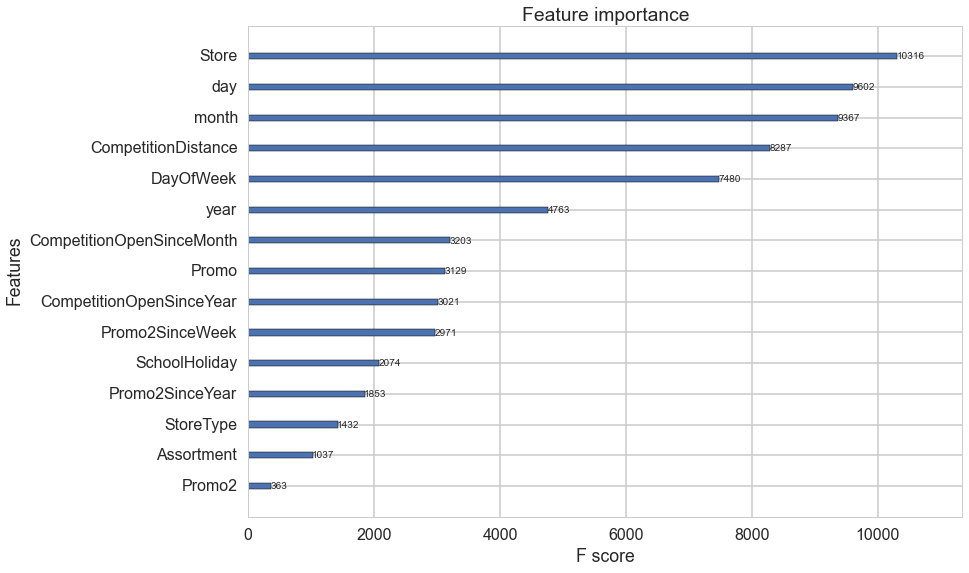

In [19]:
xgb.plot_importance(gbm)

In [20]:
print("Validating")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['Sales'].values)
print('Train error', error)

print("Make predictions on the test set")
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission.to_csv("../submissions/xgboost_kscript_submission.csv", index=False)       

Validating
Train error 0.125068655574
Make predictions on the test set
